# Predicción de existencia de penetracion de Banda Ancha fija (fibra óptica o cable coaxial) en municipios

El problema a evaluar es si dentro de los municipios hay penetracion de BAF basada en fibra óptica o cable coaxial en municipios, independientemente de su nivel.

**Nota:** Se empleó un modelo de regresión logística, XGBoost y Random Forest

### Preámbulo de paquetes a utilizarse

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import roc_auc_score


import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

### Carga de datos de penetracion BAF y municipios

In [3]:
# Cargamos los datos en crudo y creamos una copia para trabajar
raw_data = pd.read_csv ('BAF_06209_P1.csv')
data = raw_data

# Elimina columnas de municipio y clases de penetracion (solo estudiaremos si hay o no penetracion de F.O y Cable Coax.)
del data['K_ENTIDAD_MUNICIPIO']
del data['CLASS_PEN_BAF_HABS_COAXFO'] #
del data['NUM_OPS'] #
del data['DISP_INTERNET'] #
del data['ANALF'] #

# Renombramos una columna para que no genere problemas con Scikit Learn
data.rename(columns={"PL<5000": "PL5000"}, inplace=True)

# Renombramos una columnas para facilitar manipulacion
data.rename(columns={"ANOS_PROMEDIO_DE_ESCOLARIDAD": "AVG_ESCOLARIDAD"}, inplace=True)
data.rename(columns={"IS_PEN_BAF_HABS_COAXFO": "EXIST_PEN"}, inplace=True)

# Sustitumos valores de la columnas NUM_OPS (1= Hay mas de dos operadores, 0 = en otro caso)
#data['NUM_OPS'] = np.where(data['NUM_OPS']>1,1,0)

# Descartamos los municipios que no poseen indicadores de ingreso anual bruto per capita
data.dropna(inplace=True)

### Resumen de las variables en estudio

In [4]:
data.describe()

,HOGARES,POBLACION,SUPERFICIE,DENS_HOGS,DENS_HABS,SPRIM,AVG_ESCOLARIDAD,OVSAE,OVSEE,PL5000,PO2SM,INGRESOPC_ANUAL,DISP_TV_PAGA,DISP_TEL_CELULAR,DISP_TEL_FIJO,EXIST_PEN
count,2446.000000,2.446000e+03,2446.000000,2446.000000,2446.000000,2446.000000,2446.000000,2446.000000,2446.000000,2446.000000,2446.000000,2446.000000,2446.000000,2446.000000,2446.000000,2446.000000
mean,12991.372036,4.860599e+04,791.321885,7916.018110,7916.018110,29.213050,6.423426,8.651132,2.169366,71.898684,55.381063,1935.145724,31.158202,57.439859,20.204734,0.321341
std,38143.144359,1.389142e+05,2104.590464,35001.243252,35001.243252,11.862555,1.767869,11.487796,3.410109,34.685724,16.985484,1020.473455,18.829657,25.072398,14.044259,0.467087
min,31.000000,8.700000e+01,2.210000,4.995331,4.995331,2.490000,1.460000,0.000000,0.000000,0.000000,8.250000,185.290000,0.000000,0.000000,0.000000,0.000000
25%,1111.750000,4.253000e+03,85.765000,521.867640,521.867640,20.500000,5.190000,1.492500,0.490000,42.687500,42.930000,1198.730000,15.313693,42.198730,9.047367,0.000000
50%,3471.500000,1.340400e+04,233.485000,1387.721595,1387.721595,29.405000,6.280000,4.060000,1.175000,100.000000,57.020000,1789.905000,29.018092,64.877177,17.645177,0.000000
75%,8877.500000,3.439950e+04,654.895000,3462.189955,3462.189955,37.345000,7.520000,10.865000,2.560000,100.000000,68.470000,2447.497500,45.173174,76.445478,29.454433,1.000000
max,495665.000000,1.827868e+06,53138.790000,598127.340824,598127.340824,71.240000,13.830000,98.880000,57.960000,100.000000,94.120000,9748.530000,85.097192,95.002027,84.047612,1.000000


### Variables de la base

In [5]:
list(data.columns.values)

['HOGARES',
 'POBLACION',
 'SUPERFICIE',
 'DENS_HOGS',
 'DENS_HABS',
 'SPRIM',
 'AVG_ESCOLARIDAD',
 'OVSAE',
 'OVSEE',
 'PL5000',
 'PO2SM',
 'INGRESOPC_ANUAL',
 'DISP_TV_PAGA',
 'DISP_TEL_CELULAR',
 'DISP_TEL_FIJO',
 'EXIST_PEN']

### Dimensiones de la base

In [6]:
m, n = data.shape

### Matrices de correlación

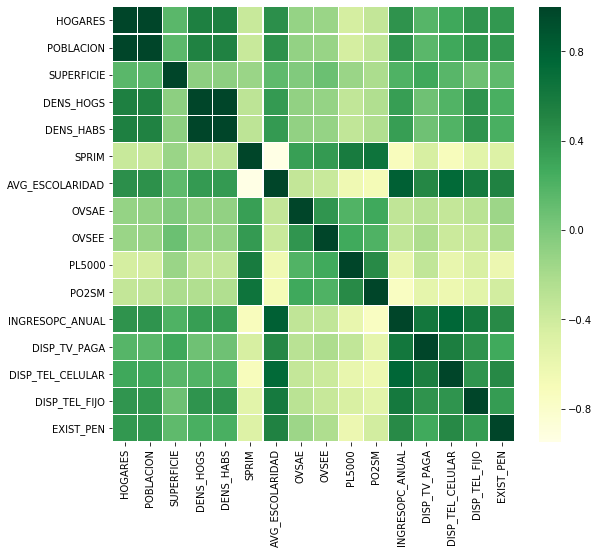

In [7]:
corrmat = data.corr() 
  
f, ax = plt.subplots(figsize =(9, 8)) 
sns.heatmap(corrmat, ax = ax, cmap ="YlGn", linewidths = 0.1)

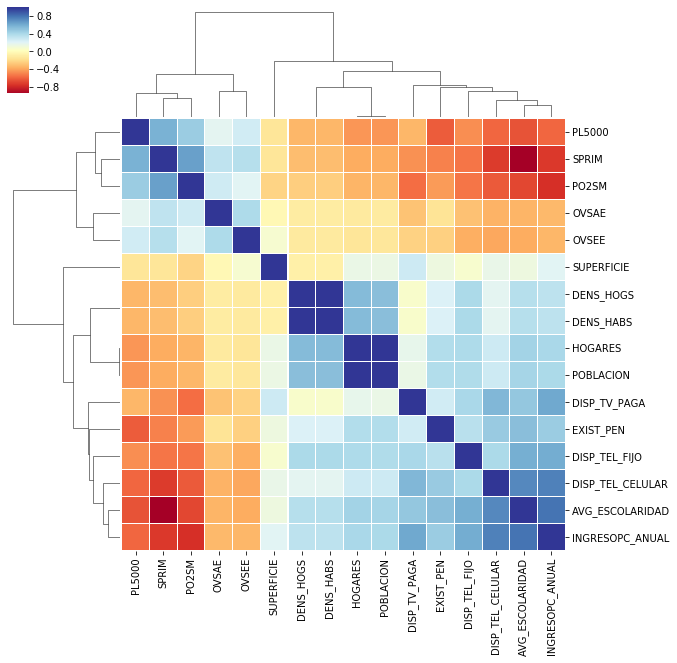

In [8]:
#corrmat = data.corr()   
cg = sns.clustermap(corrmat, cmap ="RdYlBu", linewidths = 0.1); 
plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation = 0) 
  
cg

EXIST_PEN
0    1660
1     786
dtype: int64

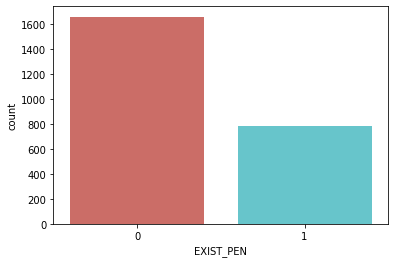

In [9]:
sns.countplot(x='EXIST_PEN',data=data,palette='hls')
data.groupby(['EXIST_PEN']).size()

### Preparamos los datos para entrenamiento y prueba

In [10]:
from sklearn.model_selection import train_test_split
seed = 721 # Seed para poder replicar
X_train, X_test, y_train, y_test = train_test_split(data.iloc[:, :n-1], data.iloc[:, n-1], random_state=seed)

xg_train = xgb.DMatrix(X_train, label=y_train)
xg_test = xgb.DMatrix(X_test, label=y_test)

/home/cesar/.local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


### Modelo con regresion logística

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing

In [12]:
model_lr = LogisticRegression(random_state=seed,solver='lbfgs', max_iter=10000, class_weight = "balanced").fit(preprocessing.scale(X_train), y_train)

In [13]:
y_model_lr_predicted = model_lr.predict(preprocessing.scale(X_test))

Accuracy: 0.8676470588235294
              precision    recall  f1-score   support

           0       0.88      0.91      0.90       387
           1       0.84      0.79      0.81       225

    accuracy                           0.87       612
   macro avg       0.86      0.85      0.86       612
weighted avg       0.87      0.87      0.87       612



Text(91.68, 0.5, 'Valor real')

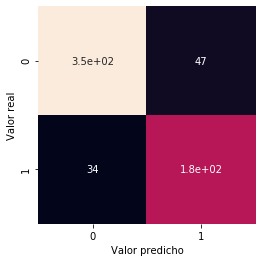

In [14]:
## Accuracy
from sklearn.metrics import accuracy_score
print("Accuracy: {}".format(accuracy_score(y_test, y_model_lr_predicted)))

## Métricas clasicas de Clasificadores
from sklearn import metrics
print(metrics.classification_report(y_model_lr_predicted, y_test))

## Matriz de confusión
from sklearn.metrics import confusion_matrix

mat_lr = confusion_matrix(y_test, y_model_lr_predicted)

plt.close()

sns.heatmap(mat_lr, square = True, annot = True, cbar = False)
plt.xlabel('Valor predicho')
plt.ylabel('Valor real')

### Modelo con XGBoost

In [27]:
from sklearn.model_selection import GridSearchCV

# Instanciamos el clasificador
classifier_xgb = xgb.XGBClassifier() 

# Hiper-parametros para hacer el grid search
hyper_param_grid = {
    'objective':['multi:softmax'],
    'eta':[0.01, 0.05,0.1], # Tasa de aprendizaje
    'gamma': [0.5],
    'max_depth':[6,7,8],
    'subsample':[0.8],
    'silent':[1],
    'nthread':[10],
    'num_class':[2],
    'subsample':[0.5],
    'colsample_bytree':[1.0],
    'n_estimators': [10, 100, 100], #number of trees, change it to 1000 for better results
    'seed':[27]
    }

model_gsearch_xgb = GridSearchCV(classifier_xgb, hyper_param_grid, cv = 6, verbose = 2)

model_gsearch_xgb.fit(X_train, y_train, eval_metric='auc')

Fitting 6 folds for each of 27 candidates, totalling 162 fits
[CV] colsample_bytree=1.0, eta=0.01, gamma=0.5, max_depth=6, n_estimators=10, nthread=10, num_class=2, objective=multi:softmax, seed=27, silent=1, subsample=0.5 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  colsample_bytree=1.0, eta=0.01, gamma=0.5, max_depth=6, n_estimators=10, nthread=10, num_class=2, objective=multi:softmax, seed=27, silent=1, subsample=0.5, total=   0.3s
[CV] colsample_bytree=1.0, eta=0.01, gamma=0.5, max_depth=6, n_estimators=10, nthread=10, num_class=2, objective=multi:softmax, seed=27, silent=1, subsample=0.5 
[CV]  colsample_bytree=1.0, eta=0.01, gamma=0.5, max_depth=6, n_estimators=10, nthread=10, num_class=2, objective=multi:softmax, seed=27, silent=1, subsample=0.5, total=   0.2s
[CV] colsample_bytree=1.0, eta=0.01, gamma=0.5, max_depth=6, n_estimators=10, nthread=10, num_class=2, objective=multi:softmax, seed=27, silent=1, subsample=0.5 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV]  colsample_bytree=1.0, eta=0.01, gamma=0.5, max_depth=6, n_estimators=10, nthread=10, num_class=2, objective=multi:softmax, seed=27, silent=1, subsample=0.5, total=   0.5s
[CV] colsample_bytree=1.0, eta=0.01, gamma=0.5, max_depth=6, n_estimators=10, nthread=10, num_class=2, objective=multi:softmax, seed=27, silent=1, subsample=0.5 
[CV]  colsample_bytree=1.0, eta=0.01, gamma=0.5, max_depth=6, n_estimators=10, nthread=10, num_class=2, objective=multi:softmax, seed=27, silent=1, subsample=0.5, total=   0.3s
[CV] colsample_bytree=1.0, eta=0.01, gamma=0.5, max_depth=6, n_estimators=10, nthread=10, num_class=2, objective=multi:softmax, seed=27, silent=1, subsample=0.5 
[CV]  colsample_bytree=1.0, eta=0.01, gamma=0.5, max_depth=6, n_estimators=10, nthread=10, num_class=2, objective=multi:softmax, seed=27, silent=1, subsample=0.5, total=   0.1s
[CV] colsample_bytree=1.0, eta=0.01, gamma=0.5, max_depth=6, n_estimators=10, nthread=10, num_class=2, objective=multi:softmax, seed=27, silent=1

[Parallel(n_jobs=1)]: Done 162 out of 162 | elapsed:  2.5min finished


GridSearchCV(cv=6, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_l...
                                     subsample=1, verbosity=1),
             iid='warn', n_jobs=None,
             param_grid={'colsample_bytree': [1.0], 'eta': [0.01, 0.05, 0.1],
                         'gamma': [0.5], 'max_depth': [6, 7, 8],
                         'n_estimators': [10, 100, 100], 'nthread': [10],
                         'num_class'

In [28]:
model_gsearch_xgb.best_params_

{'colsample_bytree': 1.0,
 'eta': 0.01,
 'gamma': 0.5,
 'max_depth': 6,
 'n_estimators': 100,
 'nthread': 10,
 'num_class': 2,
 'objective': 'multi:softmax',
 'seed': 27,
 'silent': 1,
 'subsample': 0.5}

In [29]:
model_gsearch_xgb.best_score_

0.8816793893129771

Accuracy: 0.8627450980392157
              precision    recall  f1-score   support

           0       0.93      0.87      0.90       424
           1       0.75      0.84      0.79       188

    accuracy                           0.86       612
   macro avg       0.84      0.86      0.84       612
weighted avg       0.87      0.86      0.86       612



Text(91.68, 0.5, 'Valor real')

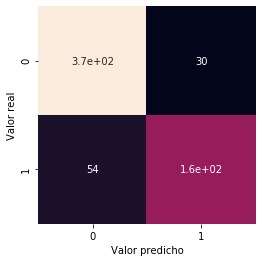

In [30]:
y_model_xgb = model_gsearch_xgb.predict(X_test)
## Accuracy
from sklearn.metrics import accuracy_score
print("Accuracy: {}".format(accuracy_score(y_test, y_model_xgb)))

## Métricas clasicas de Clasificadores
from sklearn import metrics
print(metrics.classification_report(y_model_xgb, y_test))

## Matriz de confusión
from sklearn.metrics import confusion_matrix

mat = confusion_matrix(y_test, y_model_xgb)

plt.close()

sns.heatmap(mat, square = True, annot = True, cbar = False)
plt.xlabel('Valor predicho')
plt.ylabel('Valor real')

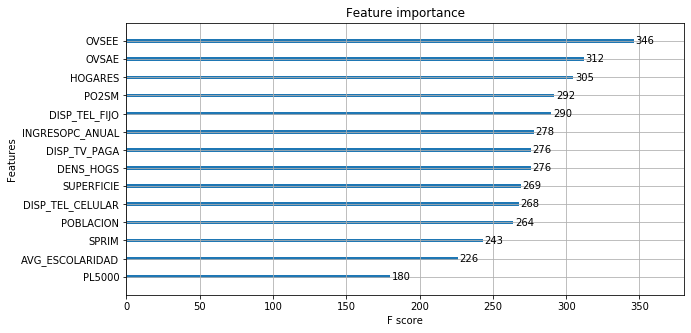

In [31]:
# How the importance is calculated: either "weight", "gain", or "cover" 
#    "weight" is the number of times a feature appears in a tree 
#    "gain" is the average"gain"of splits which use the feature 
#    "cover" is the average coverage of splits which use the feature
#      where coverage is defined as the number of samples affected by the split

fig, ax = plt.subplots(figsize=(10,5))
xgb.plot_importance(model_gsearch_xgb.best_estimator_, ax=ax, importance_type='weight')
plt.show()

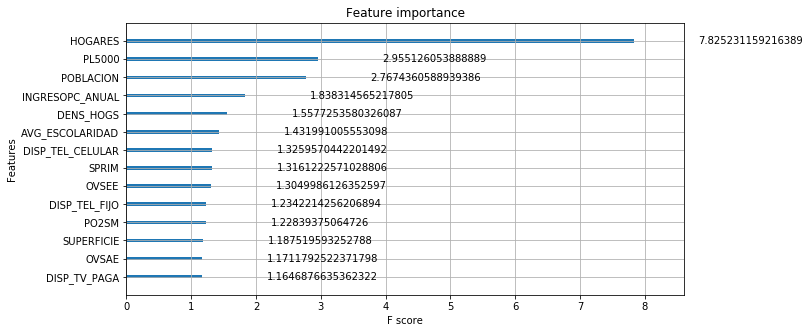

In [32]:
# How the importance is calculated: either "weight", "gain", or "cover" 
#    "weight" is the number of times a feature appears in a tree 
#    "gain" is the average"gain"of splits which use the feature 
#    "cover" is the average coverage of splits which use the feature
#      where coverage is defined as the number of samples affected by the split

fig, ax = plt.subplots(figsize=(10,5))
xgb.plot_importance(model_gsearch_xgb.best_estimator_, ax=ax, importance_type='gain')
plt.show()

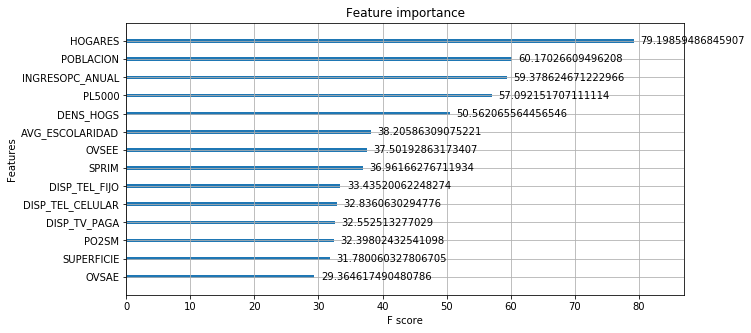

In [33]:
# How the importance is calculated: either "weight", "gain", or "cover" 
#    "weight" is the number of times a feature appears in a tree 
#    "gain" is the average"gain"of splits which use the feature 
#    "cover" is the average coverage of splits which use the feature
#      where coverage is defined as the number of samples affected by the split

fig, ax = plt.subplots(figsize=(10,5))
xgb.plot_importance(model_gsearch_xgb.best_estimator_, ax=ax, importance_type='cover')
plt.show()

In [34]:
import shap

# Create object that can calculate shap values
explainer = shap.TreeExplainer(model_gsearch_xgb.best_estimator_)

# Calculate shap_values for all of val_X rather than a single row, to have more data for plot.
shap_values = explainer.shap_values(X_test)

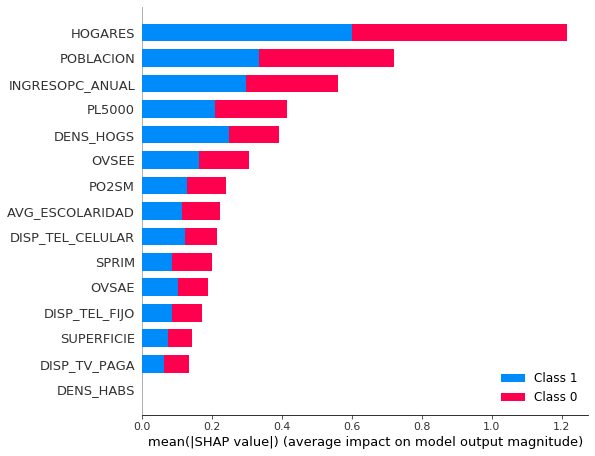

In [35]:
shap.summary_plot(shap_values, X_test) # Plot de los que no tienen conectividad de BAF (f.o. + coaxial)

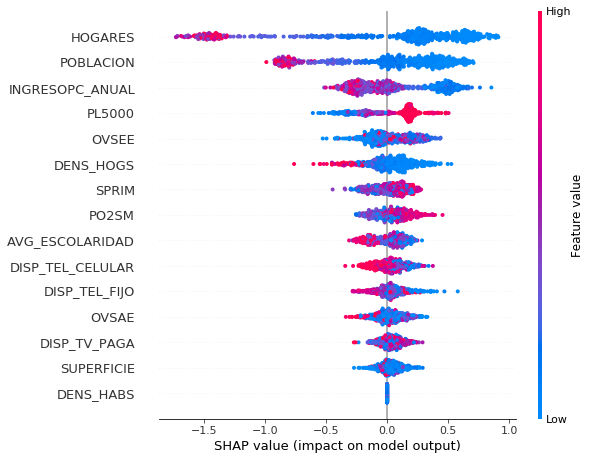

In [36]:
# Make plot. Index of [0] is explained in text below.
shap.summary_plot(shap_values[0], X_test) # Plot de los que no tienen conectividad de BAF (f.o. + coaxial)

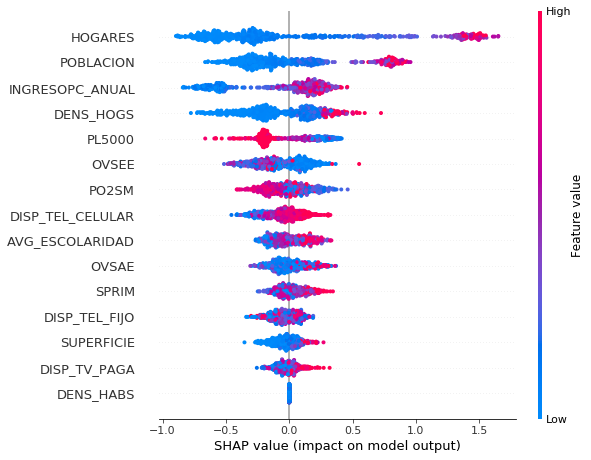

In [37]:
shap.summary_plot(shap_values[1], X_test) # Plot de los que si tienen conectividad de BAF (f.o. + coaxial)

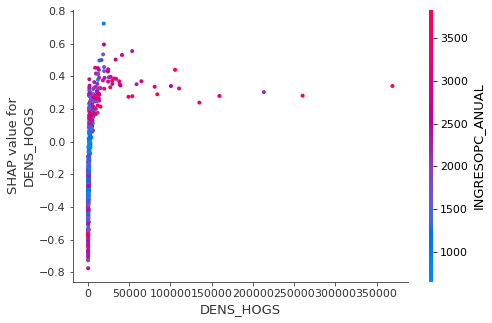

In [38]:
# https://www.kaggle.com/dansbecker/advanced-uses-of-shap-values

shap.dependence_plot('DENS_HOGS', shap_values[1], X_test, interaction_index="INGRESOPC_ANUAL")

### Random forests

In [39]:
from sklearn.model_selection import GridSearchCV

rf_classifier = RandomForestClassifier() 
hyper_param_grid = {'n_estimators': [1,10,100],#[1,10,100,1000,10000], 
                    'max_depth': [5,10,20,50,100],#5,10,20,50,100], 
                    'max_features': ['sqrt','log2'],
                    'min_samples_split': [2,5,10],
                    'criterion':['entropy'],
                    #'class_weight':['balanced'],
                    'warm_start' :['TRUE'],
                    'random_state':[712]
                   },


model_RF_gsearch = GridSearchCV(rf_classifier, hyper_param_grid, cv = 6, verbose = 3)

model_RF_gsearch.fit(X_train, y_train)

y_model_forest = model_RF_gsearch.predict(X_test)

Fitting 6 folds for each of 90 candidates, totalling 540 fits
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_split=2, n_estimators=1, random_state=712, warm_start=TRUE 
[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_split=2, n_estimators=1, random_state=712, warm_start=TRUE, score=0.827, total=   0.1s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_split=2, n_estimators=1, random_state=712, warm_start=TRUE 
[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_split=2, n_estimators=1, random_state=712, warm_start=TRUE, score=0.843, total=   0.0s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_split=2, n_estimators=1, random_state=712, warm_start=TRUE 
[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_split=2, n_estimators=1, random_state=712, warm_start=TRUE, score=0.863, total=   0.0s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_split=2, n_estimat

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s


[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_split=2, n_estimators=10, random_state=712, warm_start=TRUE, score=0.853, total=   0.1s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_split=2, n_estimators=10, random_state=712, warm_start=TRUE 
[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_split=2, n_estimators=10, random_state=712, warm_start=TRUE, score=0.879, total=   0.0s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_split=2, n_estimators=10, random_state=712, warm_start=TRUE 
[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_split=2, n_estimators=10, random_state=712, warm_start=TRUE, score=0.889, total=   0.0s
[CV] criterion=entropy, max_depth=5, max_features=sqrt, min_samples_split=2, n_estimators=10, random_state=712, warm_start=TRUE 
[CV]  criterion=entropy, max_depth=5, max_features=sqrt, min_samples_split=2, n_estimators=10, random_state=712, warm_start=TRUE, score=0.908,

[Parallel(n_jobs=1)]: Done 540 out of 540 | elapsed:  1.8min finished


In [40]:
model_RF_gsearch.best_params_

{'criterion': 'entropy',
 'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_split': 2,
 'n_estimators': 10,
 'random_state': 712,
 'warm_start': 'TRUE'}

In [41]:
model_RF_gsearch.best_score_

0.8865866957470011

Accuracy: 0.8643790849673203
              precision    recall  f1-score   support

           0       0.93      0.87      0.90       425
           1       0.75      0.84      0.79       187

    accuracy                           0.86       612
   macro avg       0.84      0.86      0.85       612
weighted avg       0.87      0.86      0.87       612



Text(91.68, 0.5, 'Valor real')

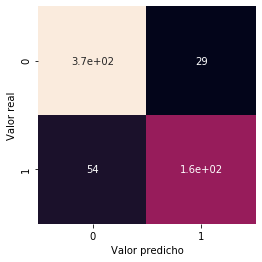

In [42]:
## Accuracy
from sklearn.metrics import accuracy_score
print("Accuracy: {}".format(accuracy_score(y_test, y_model_forest)))

## Métricas clasicas de Clasificadores
from sklearn import metrics
print(metrics.classification_report(y_model_forest, y_test))

## Matriz de confusión
from sklearn.metrics import confusion_matrix

mat = confusion_matrix(y_test, y_model_forest)

plt.close()

sns.heatmap(mat, square = True, annot = True, cbar = False)
plt.xlabel('Valor predicho')
plt.ylabel('Valor real')